In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# Import Bagging Classifier.
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import joblib
import timeit
from sklearn.svm import SVC
from sklearn.base import TransformerMixin # this allows us to create a custom transformer
pd.set_option('display.max_rows',None)

### Function to Run GridSearchCV for user provided vectorizer and model in the pipeline

In [27]:
# define a function that combines the dataframe from two subreddit,and only keep the select columns for building models
def combine_subreddit(df1,df2,col = ['subreddit','title'],subreddits = ('StarWars','marvelstudios')):
#     input: df1,df2 -> the two dataframes from two different subreddit
#            col -> list for the columns kept to use
#            subreddit -> tuple contains the two subreddit information, 'StarWars' and 'marvelstudios' are default
#     output: A dataframe combined df1 and df2 which only the columns in col, 
#             and the title column are coverted in 1(first subreddit in tuple subreddits)  and 0(the second subreddit in tuple subreddits)   
        
    data = pd.concat([df1[col],df2[col]])
    data.reset_index(inplace = True,drop=True)
    data['subreddit'] = data['subreddit'].map({subreddits[0]:1,subreddits[1]:0})
    return data     

In [28]:
#define a function that run GridSearchCV for user provided vectorizer and model
def pipe_gridsearch_cv(X = None, y = None, pipelist = None,pipe_params = None,cv = 5):
#     input: X -> the training matrix
#            y -> the training target
#            pipelist -> the list provoding the things in the Pipeline
#            pipe_params -> the parameters for the pipe line
#            cv -> the number of folds for cross validation in GridSearchCV
#      output: The best estimator from GridSearchCV with the provided parameters

    pipe = Pipeline(pipelist)
    pipe_params = pipe_params
    gs = GridSearchCV(pipe,
                      param_grid = pipe_params,
                      cv = cv)
    gs.fit(X,y)
    return gs

#### 1. Count Vectorizer and Multinomial Naive Bayes grid search

In [29]:
pipelist_cnb = [('cvec',CountVectorizer()),('nb',MultinomialNB())]
pipe_params_cnb = {
    'cvec__max_features' : [2000,3000,4000,5000,6000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'cvec__stop_words' : [None,'english']
}

In [31]:
starwars_df = pd.read_csv('./data/starwars_10000.csv')
marvel_df = pd.read_csv('./data/marvel_10000.csv')

In [32]:
data_10000 = combine_subreddit(starwars_df,marvel_df)

In [33]:
X = data_10000['title']
y = data_10000['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [34]:
# Search for the best estimator for count vectorizer + Multiple Naive Bayes flow
t_start = timeit.default_timer()
gs_cnb = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist=pipelist_cnb ,pipe_params = pipe_params_cnb)
t_end = timeit.default_timer()
print(t_end - t_start)

125.30800519999957


In [35]:
gs_cnb.best_score_

0.9002985074626866

In [36]:
gs_cnb.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=5000, min_df=2)),
                ('nb', MultinomialNB())])

In [37]:
gs_cnb.best_estimator_.score(X_train,y_train)

0.9283582089552239

In [38]:
gs_cnb.best_estimator_.score(X_test,y_test)

0.9018181818181819

In [39]:
#Save the best model from cvec-nb flow
joblib.dump(gs_cnb.best_estimator_, './data/gs_cnb_estimator.sav')

#### 2. Term frequency-inverse document frequency (TF-IDF) Vectorizer and Multinomial/Guassion Naive Bayes grid search

In [166]:
pipelist_tvec_nb = [('tvec',TfidfVectorizer()),('nb',MultinomialNB())]
pipe_tvec_params = {
    'tvec__max_features': [5_000, 6000,7000,8000],
    'tvec__min_df' : [2,3],
    'tvec__max_df' : [0.9,0.95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__norm' : ['l1','l2']
}

In [167]:
t_start = timeit.default_timer()
gs_tvec_nb = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_tvec_nb, pipe_params = pipe_tvec_params)
t_end = timeit.default_timer()
print(t_end - t_start)

132.4353986999995


In [168]:
gs_tvec_nb.best_score_

0.8988059701492539

In [169]:
gs_tvec_nb.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=6000, min_df=2)),
                ('nb', MultinomialNB())])

In [170]:
gs_tvec_nb.best_estimator_.score(X_train, y_train)

0.9375373134328359

In [171]:
gs_tvec_nb.best_estimator_.score(X_test, y_test)

0.9009090909090909

**Summary**  

  ||cvec-MNB|tvec-MNB|   
  |---|---|---|
  |train|0.928|0.937|
  |test|0.902|0.900|  

- cvec and tvec gave similar results with Multinomial Naive Bayes classifiers
- The optimized paramerters were different for cvec and tvec: 
    - cvec use english stop_words, while tvec use none stop words
    - n-gram: (1,1) vs (1,2)
- In general, TF-IDF vectorizer should work better with Gaussian Naive Bayes, I will try it next

##### TF-IDF Vectorizer and Gaussian NB model

In [40]:
# Define a class for transfer sparse matrix to array
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.toarray()

In [293]:
pipelist_tvec_gnb = [('tvec',TfidfVectorizer()),("_", DenseTransformer()),('nb',GaussianNB())]
pipe_tvec_params = {
    'tvec__max_features': [5_000, 6000,7000,8000],
    'tvec__min_df' : [2,3],
    'tvec__max_df' : [0.9,0.95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__norm' : ['l1','l2']
}

In [294]:
t_start = timeit.default_timer()
gs_tvec_gnb = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_tvec_gnb, pipe_params = pipe_tvec_params)
t_end = timeit.default_timer()
print(t_end - t_start)

1455.6972778000054


In [295]:
gs_tvec_gnb.best_score_

0.8745522388059703

In [296]:
gs_tvec_gnb.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.9, max_features=5000, min_df=3,
                                 ngram_range=(1, 2))),
                ('_', <__main__.DenseTransformer object at 0x0000015ED2472688>),
                ('nb', GaussianNB())])

In [297]:
gs_tvec_gnb.best_estimator_.score(X_train,y_train)

0.9229850746268656

In [298]:
gs_tvec_gnb.best_estimator_.score(X_test,y_test)

0.8751515151515151

**Comments**   
It seemed the Multinomial NB worked better than the Gaussian NB for this case.

#### 3. CountVectorizer and knn() grid search

**KNN without standard scaler transform**

In [347]:
pipelist_cknn = [('cvec',CountVectorizer()),('knn',KNeighborsClassifier())]

In [348]:
pipelist_cknn

[('cvec', CountVectorizer()), ('knn', KNeighborsClassifier())]

In [349]:
gs_cknn = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist=pipelist_cknn ,pipe_params = pipe_params_cnb)

In [350]:
gs_cknn.best_score_

0.8211194029850747

In [351]:
gs_cknn.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=3000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('knn', KNeighborsClassifier())])

In [386]:
#Save the best model from cvec-knn flow
joblib.dump(gs_cknn.best_estimator_, './data/gs_cknn_estimator.sav')

['./data/gs_cknn_estimator.sav']

In [432]:
gs_cknn.best_estimator_.score(X_train,y_train)

0.8847761194029851

In [433]:
gs_cknn.best_estimator_.score(X_test,y_test)

0.828939393939394

**KNN with standard scaler transform**

In [370]:
# pipelist_sc_cknn = [('cvec',CountVectorizer()),('knn',KNeighborsClassifier())]
pipelist_sc_cknn = [('cvec',CountVectorizer()),('sc',StandardScaler(with_mean = False)),('knn',KNeighborsClassifier())]

In [374]:
pipe_params_cknn = {
    'cvec__max_features' : [2000,3000,4000,5000,6000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'cvec__stop_words' : [None,'english']
}

In [375]:
t_start = timeit.default_timer()
gs_sc_cknn = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_sc_cknn, pipe_params = pipe_params_cknn)
t_end = timeit.default_timer()
print(t_end - t_start)

596.559531100007


In [376]:
gs_sc_cknn.best_score_

0.7972388059701492

In [377]:
gs_sc_cknn.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=6000, min_df=3,
                                 ngram_range=(1, 2), stop_words='english')),
                ('sc', StandardScaler(with_mean=False)),
                ('knn', KNeighborsClassifier())])

In [378]:
gs_sc_cknn.best_estimator_.score(X_train,y_train)

0.8733582089552239

In [380]:
gs_sc_cknn.best_estimator_.score(X_test,y_test)

0.7915151515151515

In [385]:
#Save the best model from cvec-standard scaler-knn flow
joblib.dump(gs_sc_cknn.best_estimator_, './data/gs_sc_cknn_estimator.sav')

['./data/gs_sc_cknn_estimator.sav']

**Comments**
- KNN models didn't perform as good as Naive Bayes models
- KNN without standard scalers seemed to be better than KNN with standard scalers for this case

#### 4. CountVectorizer and Logistic Regression grid search

In [392]:
pipelist_clgr = [('cvec',CountVectorizer()),('lgr',LogisticRegression(max_iter = 5000))]

In [390]:
pipe_params_clgr = {
    'cvec__max_features' : [2000,3000,4000,5000,6000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'cvec__stop_words' : [None,'english']
}

In [393]:
t_start = timeit.default_timer()
gs_clgr = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clgr, pipe_params = pipe_params_clgr)
t_end = timeit.default_timer()
print(t_end - t_start)

180.58468329999596


In [394]:
gs_clgr.best_score_

0.8951492537313432

In [396]:
gs_clgr.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=6000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('lgr', LogisticRegression(max_iter=5000))])

In [398]:
gs_clgr.best_estimator_.score(X_train,y_train)

0.9541044776119403

In [399]:
gs_clgr.best_estimator_.score(X_test,y_test)

0.9018181818181819

In [400]:
#Save the best model from cvec-standard scaler-knn flow
joblib.dump(gs_clgr.best_estimator_, './data/gs_clgr_estimator.sav')

['./data/gs_clgr_estimator.sav']

#### 5. Count Vectorizer and random forest model grid search

In [91]:
pipelist_crf = [('cvec',CountVectorizer()),('rf',RandomForestClassifier())]

In [92]:
pipe_params_crf = {
    'cvec__max_features' : [2000,3000,4000,5000,6000],
    'cvec__min_df' : [2,3],
    'cvec__max_df' : [0.9,0.95],
    'cvec__ngram_range' : [(1,1),(1,2),(2,2)],
    'cvec__stop_words' : [None,'english']
}

In [93]:
t_start = timeit.default_timer()
gs_crf_scan = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_crf, pipe_params = pipe_params_crf)
t_end = timeit.default_timer()
print(t_end - t_start)

2632.7706462999995


In [94]:
gs_crf_scan.best_score_

0.8852985074626865

In [95]:
gs_crf_scan.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.9, max_features=6000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('rf', RandomForestClassifier())])

In [97]:
gs_crf_scan.best_estimator_.score(X_train,y_train)

0.9871641791044776

In [98]:
gs_crf_scan.best_estimator_.score(X_test,y_test)

0.8884848484848484

In [99]:
#Save the best model from cvec-standard random forest flow
joblib.dump(gs_crf_scan.best_estimator_, './data/gs_crf_estimator.sav')

['./data/gs_crf_estimator.sav']

#### 6. Count Vectorizer and support vector machine model grid search

In [264]:
# Here the input was the dataframe after applying the optimized count vectorizer transform
# X_train_cvec, X_test_cvec were created in cells below
pipelist_sc_svc  =  [('sc',StandardScaler(with_mean = False)),('svc',SVC(probability=True))]
pipelist_svc  =  [('svc',SVC())]

In [265]:
params_svc = {
    'svc__C':[3],
    'svc__degree': [2]
}

In [266]:
t_start = timeit.default_timer()
gs_sc_svc = pipe_gridsearch_cv(X = X_train_cvec, y = y_train, pipelist = pipelist_sc_svc, pipe_params = params_svc)
t_end = timeit.default_timer()
print(t_end - t_start)

337.9834288999991


In [267]:
gs_sc_svc.best_score_

0.8428358208955224

In [268]:
gs_sc_svc.best_estimator_

Pipeline(steps=[('sc', StandardScaler(with_mean=False)),
                ('svc', SVC(C=3, degree=2, probability=True))])

In [269]:
gs_sc_svc.best_estimator_.score(X_train_cvec,y_train)

0.9701492537313433

In [270]:
gs_sc_svc.best_estimator_.score(X_test_cvec,y_test)

0.8745454545454545

**Plot the ROC curves for all the models**

In [100]:
md_csvc = gs_sc_svc.best_estimator_
md_cnb = joblib.load('./data/gs_cnb_estimator.sav')
md_clgr = joblib.load('./data/gs_clgr_estimator.sav')
md_sc_cknn = joblib.load('./data/gs_sc_cknn_estimator.sav')
md_crf = joblib.load('./data/gs_crf_estimator.sav')

In [276]:
models = [md_cnb,md_clgr,md_crf,md_csvc,md_cknn]
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for md in models:
    #model = cls.fit(X_train, y_train)
    if md == md_csvc:
        Xtest = X_test_cvec
    else:
        Xtest = X_test
    yproba = md.predict_proba(Xtest)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':list(md.named_steps.keys())[1],
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

In [277]:
result_table.head()

,fpr,tpr,auc
classifiers,,,
nb,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000...","[0.0, 0.00393939393939394, 0.00454545454545454...",0.974312
lgr,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00030303030303030303, 0.02848484848484...",0.971595
rf,"[0.0, 0.00393939393939394, 0.00393939393939394...","[0.0, 0.30757575757575756, 0.30787878787878786...",0.960937
svc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00030303030303030303, 0.00606060606060...",0.944161
knn,"[0.0, 0.024242424242424242, 0.1054545454545454...","[0.0, 0.4812121212121212, 0.7181818181818181, ...",0.912703


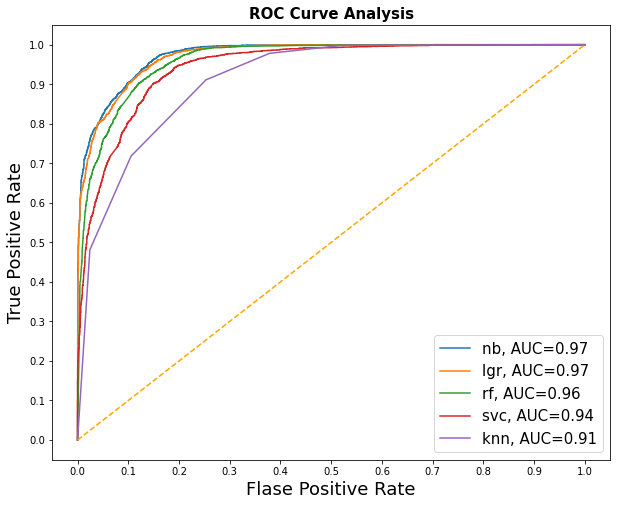

In [278]:
fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.2f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=18)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=18)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':15}, loc='lower right')

plt.savefig('./image/roc_curves_allmodels.jpeg');


**Models comparison summary**  


 | |cvec-MNB|cvec-knn|cvec-sc-knn|cvec-logistic-regression|cvec-randomforest|cvec-sc-svc|   
 |---|---|---|---|---|---|---|  
 |train|0.928|0.885|0.873|0.957|0.937|0.970|  
 |test|0.902|0.829|0.792|0.903|0.888|0.875|  

- MNB and logistic regression models gave good scores for both training and testing datasets
- Random forest and support vector machine models gave good scores for training datasets, but the scores for testing datasets are as good  
- KNN model performed not as well as other models

#### 7. Dig into the datasets

##### What are the most commmon words

In [42]:
cvec = CountVectorizer(max_df=0.9, max_features=8000, min_df=1,
                                 ngram_range=(1, 2), stop_words='english')
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)
X_train_cvec_df = pd.DataFrame(X_train_cvec.toarray(),columns = cvec.get_feature_names())
X_test_cvec_df = pd.DataFrame(X_test_cvec.toarray(),columns = cvec.get_feature_names())

In [43]:
# The top 30 common words in train datasets
most_freq = X_train_cvec_df.sum().sort_values(ascending=False).head(30)

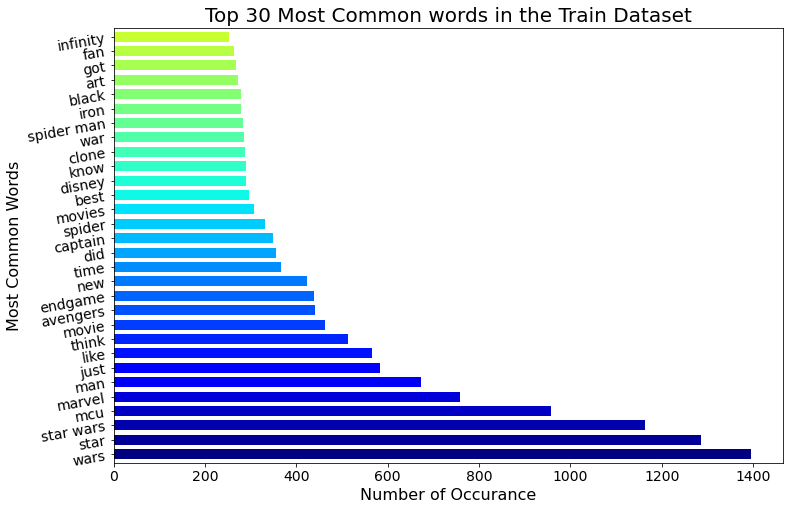

In [44]:
plt.figure(figsize = (12,8))
most_freq.plot.barh(width = 0.7,color = cm.jet(np.linspace(0,1)))
plt.xticks(fontsize = 14)
plt.yticks(rotation = 10,fontsize = 14)
plt.xlabel('Number of Occurance', fontsize = 16)
plt.ylabel('Most Common Words', fontsize = 16)
plt.title("Top 30 Most Common words in the Train Dataset", fontsize = 20)
plt.savefig('./image/Top30words_train.jpeg');

In [45]:
# The top 30 common words in testing datasets
test_most_freq = X_test_cvec_df.sum().sort_values(ascending=False).head(30)

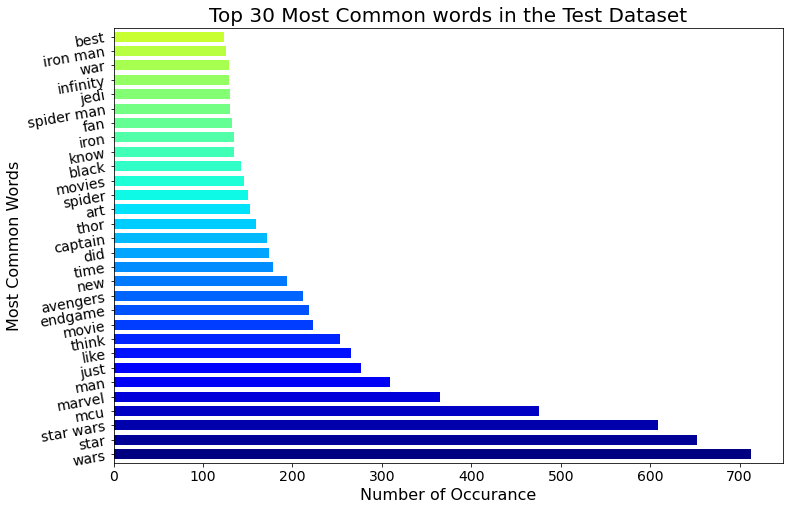

In [46]:
plt.figure(figsize = (12,8))
test_most_freq.plot.barh(width = 0.7,color = cm.jet(np.linspace(0,1)))
plt.xticks(fontsize = 14)
plt.yticks(rotation = 10,fontsize = 14)
plt.xlabel('Number of Occurance', fontsize = 16)
plt.ylabel('Most Common Words', fontsize = 16)
plt.title("Top 30 Most Common words in the Test Dataset", fontsize = 20)
plt.savefig('./image/Top30words_test.jpeg');

**Comments** 
- The top 30 most common used words were pretty similar in the training and testing datasets
- Only two words were different: training datasets had "fan" and "got", testing datasets had "iron man" and "jedi"

#### 8. Search for the optimized paramerters for logistic regression models

In [207]:
# Note, not all the searched parameters were listed below.
pipelist_clr_scan = [('cvec',CountVectorizer(stop_words='english',max_features=8000)),('lr',LogisticRegression(max_iter = 5000))]
pipe_params_clr_scan = {
    'cvec__max_features' : [7000,8000,9000,12000],
    'cvec__min_df' : [1,2,3], # min_df = 1 is the best, thought the impact is small
    'cvec__max_df' : [0.3,0.4,0.5,0.6,0.7,0.8,0.9], # all max_df gave same results
    'cvec__ngram_range' : [(1,2)],
    'lr__penalty' : ['l1','l2'],
    'lr__C' : [1,1.2,1.5,2],
    'lr__solver' : ['liblinear']
}

In [47]:
t_start = timeit.default_timer()
gs_clr_scan = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clr_scan, pipe_params = pipe_params_clr_scan)
t_end = timeit.default_timer()
print(t_end - t_start)

In [205]:
gs_clr_scan.best_score_

0.8962686567164179

In [279]:
gs_clr_scan.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_features=8000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('lr',
                 LogisticRegression(C=1.2, max_iter=5000, solver='liblinear'))])

In [403]:
gs_clr_scan.best_estimator_.named_steps

{'cvec': CountVectorizer(max_features=8000, ngram_range=(1, 2), stop_words='english'),
 'lr': LogisticRegression(C=1.2, max_iter=5000, solver='liblinear')}

In [194]:
gs_clr_scan.best_estimator_.score(X_train,y_train)

0.9608955223880598

In [195]:
gs_clr_scan.best_estimator_.score(X_test,y_test)

0.9025757575757576

In [280]:
logreg = gs_clr_scan.best_estimator_

**Creating the confusion matrix for the best estimator**

In [281]:
preds = logreg.predict(X_test)
print(confusion_matrix(y_test,preds))

[[2842  458]
 [ 185 3115]]


In [282]:
tn,fp,fn,tp = confusion_matrix(y_test,preds).ravel()

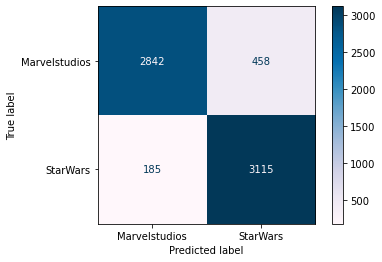

In [283]:
plot_confusion_matrix(logreg,
                      X_test,
                      y_test,
                      display_labels=['Marvelstudios','StarWars'],
                      cmap='PuBu', 
                      values_format='d')
plt.savefig('./image/confusion_matrix_lr.jpeg');

In [284]:
spec = tn / (tn + fp)
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')
print(f'Specificity: {round(spec,4)}')

Sensitivity: 0.9439
Specificity: 0.8612


**Observations:**  
- Sensitivity is better than specivicity which means the model has higher accuracy on predicting posts in StarWars than in marvelstudios
- There might be some words commonly used in starwars were also commonly used in marvelstodios

##### Checking the large coefficients in the Logistic Regression model

In [ ]:
# refit the model with the best parameters and vectorzied X_train and y_train

In [48]:
lr = LogisticRegression(C=1.2,max_iter=5000,solver='liblinear')

In [49]:
lr.fit(X_train_cvec,y_train)

LogisticRegression(C=1.2, max_iter=5000, solver='liblinear')

In [50]:
lr.score(X_train_cvec,y_train)

0.9608955223880598

In [14]:
lr.score(X_test_cvec,y_test)

0.9030303030303031

In [15]:
coef_starwarts = pd.DataFrame(lr.coef_,columns=X_train_cvec_df.columns,index = ['coef']).T['coef'].sort_values(ascending=False).head(15)

In [16]:
coef_marvel = pd.DataFrame(lr.coef_,columns=X_train_cvec_df.columns,index = ['coef']).T['coef'].sort_values(ascending=False).tail(15).sort_values()

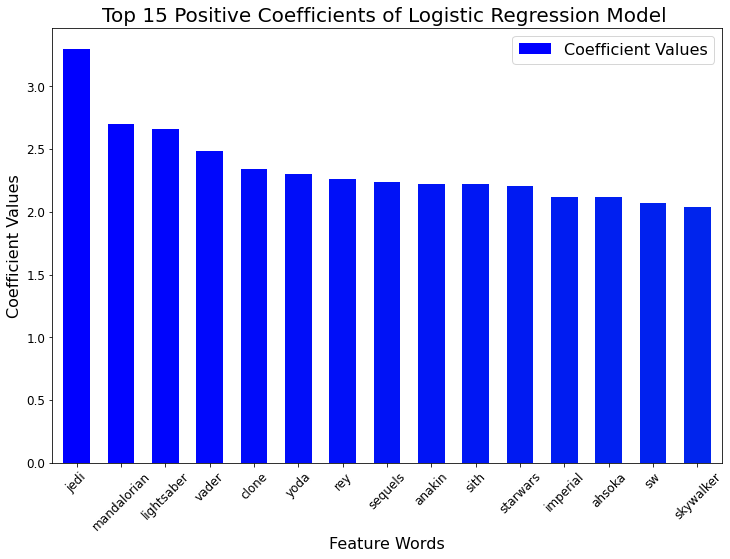

In [160]:
plt.figure(figsize = (12,8))
coef_starwarts.plot.bar(width = 0.6,color = cm.winter(np.linspace(0,0.5)),label = 'Coefficient Values')
plt.yticks(fontsize = 12)
plt.xticks(rotation = 45,fontsize = 12)
plt.ylabel('Coefficient Values', fontsize = 16)
plt.xlabel('Feature Words', fontsize = 16)
plt.title("Top 15 Positive Coefficients of Logistic Regression Model ", fontsize = 20)
plt.legend(fontsize = 16)
plt.savefig('./image/Top15_positive_coef.jpeg');

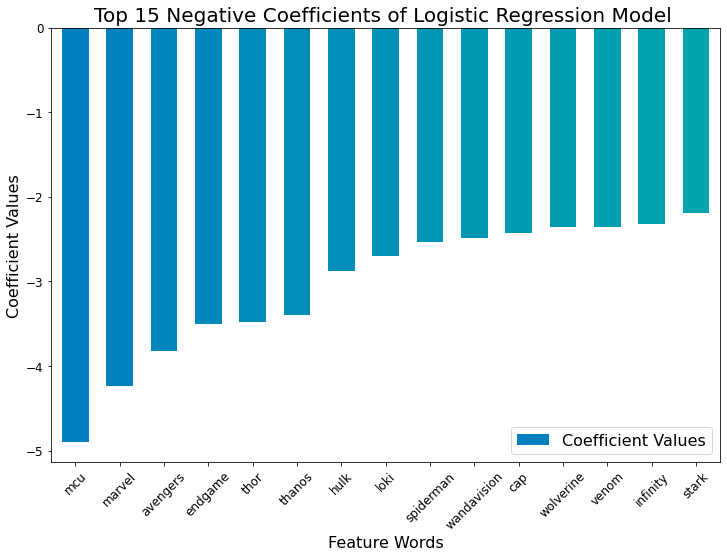

In [161]:
plt.figure(figsize = (12,8))
coef_marvel.plot.bar(width = 0.6,color = cm.winter(np.linspace(0.5,1)),label = 'Coefficient Values')
plt.yticks(fontsize = 12)
plt.xticks(rotation = 45,fontsize = 12)
plt.ylabel('Coefficient Values', fontsize = 16)
plt.xlabel('Feature Words', fontsize = 16)
plt.title("Top 15 Negative Coefficients of Logistic Regression Model ", fontsize = 20)
plt.legend(fontsize = 16)
plt.savefig('./image/Top15_negative_coef.jpeg');

##### How about removing the top 15 driving words?

In [303]:
coef_marvel.index

Index(['mcu', 'marvel', 'avengers', 'endgame', 'thor', 'thanos', 'hulk',
       'loki', 'spiderman', 'wandavision', 'cap', 'wolverine', 'venom',
       'infinity', 'stark'],
      dtype='object')

In [300]:
coef_starwarts.index

Index(['jedi', 'mandalorian', 'lightsaber', 'vader', 'clone', 'yoda', 'rey',
       'sequels', 'anakin', 'sith', 'starwars', 'imperial', 'ahsoka', 'sw',
       'skywalker'],
      dtype='object')

In [324]:
stop_star = (list(coef_starwarts.index)) + list(CountVectorizer(stop_words = 'english').get_stop_words())

In [325]:
stop_marvel = (list(coef_marvel.index)) + list(CountVectorizer(stop_words = 'english').get_stop_words())

##### 3 cases were tested:
- Removing the words of the top 15 positive coefficients
- Removing the words of the top 15 negative coefficients
- Removing the words of the both top 15 positive and negative coefficients

In [334]:
pipelist_clr_stopstar = [('cvec',CountVectorizer(stop_words=stop_star,max_features=8000)),('lr',LogisticRegression(max_iter = 5000))]
pipelist_clr_stopmarvel = [('cvec',CountVectorizer(stop_words=stop_marvel,max_features=8000)),('lr',LogisticRegression(max_iter = 5000))]
pipelist_clr_stopboth = [('cvec',CountVectorizer(stop_words=stop_marvel+stop_star,max_features=8000)),('lr',LogisticRegression(max_iter = 5000))]
pipe_params_clr_stop = {
#    'cvec__max_features' : [7000,8000,9000,12000],
#    'cvec__min_df' : [1,2,3], # min_df = 1 is the best, thought the impact is small
#    'cvec__max_df' : [0.3,0.4,0.5,0.6,0.7,0.8,0.9], # all max_df gave same results
    'cvec__ngram_range' : [(1,2)],
#    'lr__penalty' : ['l1','l2'],
    'lr__C' : [1.2],
    'lr__solver' : ['liblinear']
}

In [329]:
t_start = timeit.default_timer()
gs_clr_stopstar = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clr_stopstar, pipe_params = pipe_params_clr_stop)
gs_clr_stopmarvel = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clr_stopmarvel, pipe_params = pipe_params_clr_stop)
t_end = timeit.default_timer()
print(t_end - t_start)

4.213978300016606


In [330]:
gs_clr_stopstar.best_score_

0.8892537313432836

In [331]:
gs_clr_stopmarvel.best_score_

0.8591791044776119

In [332]:
print(gs_clr_stopstar.best_estimator_.score(X_train,y_train))
print(gs_clr_stopstar.best_estimator_.score(X_test,y_test))

0.9541791044776119
0.8953030303030303


In [333]:
print(gs_clr_stopmarvel.best_estimator_.score(X_train,y_train))
print(gs_clr_stopmarvel.best_estimator_.score(X_test,y_test))

0.9455970149253732
0.8666666666666667


In [335]:
t_start = timeit.default_timer()
gs_clr_stopboth = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clr_stopboth, pipe_params = pipe_params_clr_stop)
t_end = timeit.default_timer()
print(t_end - t_start)

1.9553128999832552


In [336]:
gs_clr_stopboth.best_score_

0.839402985074627

In [337]:
print(gs_clr_stopboth.best_estimator_.score(X_train,y_train))
print(gs_clr_stopboth.best_estimator_.score(X_test,y_test))

0.9365671641791045
0.8537878787878788


In [338]:
print(confusion_matrix(y_test,gs_clr_stopboth.best_estimator_.predict(X_test)))

[[2737  563]
 [ 402 2898]]


In [339]:
tn,fp,fn,tp = confusion_matrix(y_test,gs_clr_stopboth.best_estimator_.predict(X_test)).ravel()

In [340]:
spec = tn / (tn + fp)
sens = tp / (tp + fn)
print(f'Sensitivity: {round(sens,4)}')
print(f'Specificity: {round(spec,4)}')

Sensitivity: 0.8782
Specificity: 0.8294


**Comments**  
Removing the words with top positive or negative coeficients would reduce the logistic regression model's performance:
- lower accuracy
- lower sensitivity
- lower specificity

#### 10. How to reduce the overfitting of the Logistic Regression model?
##### A. Bagging logistic regression models

In [210]:
# Bag 10 logistic regressions 
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(C=1.2,max_iter=5000,solver='liblinear',)
baglog = BaggingClassifier(random_state=42, base_estimator=lgr,n_estimators = 100)
# Fit BaggingClassifier.
baglog.fit(X_train_cvec, y_train)
# Score BaggingClassifier.
baglog.score(X_test_cvec, y_test)

0.9016666666666666

In [211]:
baglog.score(X_test_cvec,y_test)

0.9016666666666666

In [342]:
baglog.score(X_train_cvec,y_train)

0.9539552238805971

In [212]:
gs_clr_scan.best_estimator_.score(X_test,y_test)

0.9025757575757576

**Comments**  
Bagging logistic regression models seemed not to have imporvements on the overfitting of the logistic models.

##### B. Reducing the max features in the count vectorizer

In [375]:
pipelist_clr_maxfeature = [('cvec',CountVectorizer(stop_words='english')),('lr',LogisticRegression(max_iter = 5000))]
scores = []
for max_feature in np.linspace(200,8000,40):
    pipe_params_clr_maxfeature = {
    'cvec__max_features' : [int(max_feature)],
    'cvec__ngram_range' : [(1,2)],
    'lr__C' : [1.2],
    'lr__solver' : ['liblinear']
    }
    gs = pipe_gridsearch_cv(X = X_train, y = y_train, pipelist = pipelist_clr_maxfeature, pipe_params = pipe_params_clr_maxfeature)
    train_score = gs.best_estimator_.score(X_train,y_train)
    test_score = gs.best_estimator_.score(X_test,y_test)
    scores.append({ 'max_feature': int(max_feature),
                    'cv_score': gs.best_score_,
                    'train' : train_score,
                    'test' : test_score
                  })

In [402]:
scores_df = pd.DataFrame(scores)
scores_df.set_index('max_feature',inplace=True)
scores_df.head(2)

,cv_score,train,test
max_feature,,,
200,0.818358,0.827164,0.826818
400,0.850746,0.866493,0.856515


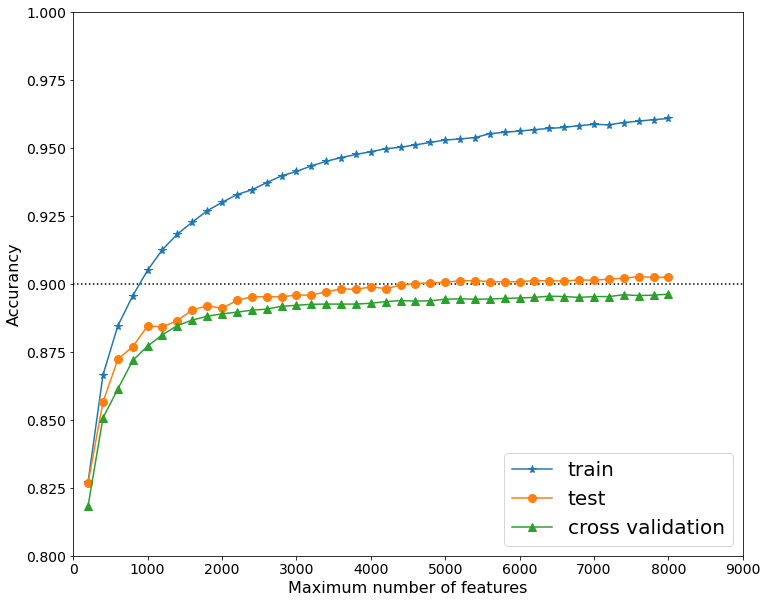

In [398]:
plt.figure(figsize = (12,10))
plt.plot(scores_df['train'],'-*',label = 'train',markersize = 8)
plt.plot(scores_df['test'],'-o',label = 'test',markersize = 8)
plt.plot(scores_df['cv_score'],'-^',label = 'cross validation',markersize = 8)
plt.xlim(0,9000)
plt.ylim(0.8,1)
plt.xlabel("Maximum number of features",fontsize = 16)
plt.ylabel("Accurancy",fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.hlines(0.9,0,40000,linestyle = 'dotted')
plt.legend(fontsize = 20,loc = 'lower right')
plt.savefig('./image/lgr_scores_maxfeatures.jpeg');

**Comments**
- When the number of features in Count vectorizers was small (i.e. < 1000), the logistic regression models seemed not to be overfitted, but the overall scores were not good either.  
- As the number of features increased, both the training and test datasets were fitted better. The scores of the training datasets growed faster than the testing datasets, which indicated overfitting of the model.
- The testing scores were pretty consistent with the cross-validation scores.